#Cifar10
In the following we will use a Residual Network and Dense Net respectively to classify the Cifar10 dataset. 
We have tried to build comparably deep architectures.

In [53]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import time

First we load the dataset and take a look at it to find out more about it's properties.

In [54]:
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


The shape of the image set:  (50000, 32, 32, 3)
The shape of the label set:  (50000, 1)
Print a label:  [9]


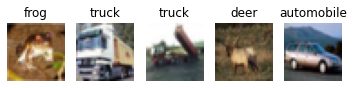

In [55]:
print("The shape of the image set: ", train_images.shape)
print("The shape of the label set: ", train_labels.shape)
print("Print a label: ", train_labels[1])
name_dict = {0: "airplane",1:"automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
fig, ax = plt.subplots(1,5)

for count in range(5):
  img = train_images[count]
  label = int(train_labels[count])
  ax[count].imshow(img)
  ax[count].set_title(name_dict[label])
  ax[count].axis("off")

## Preprocessing

Perform necessary preprocessing steps to prepare the images and labels.

In [56]:
train_images = tf.data.Dataset.from_tensor_slices(train_images)

#normalizing image
train_images = train_images.map(lambda img: img/255)

train_labels = tf.data.Dataset.from_tensor_slices(train_labels.reshape((-1,)))
train_labels = train_labels.map(lambda label: tf.one_hot(label,10))

training_data = tf.data.Dataset.zip((train_images, train_labels))
training_data = training_data.batch(64)
training_data = training_data.shuffle(buffer_size = 64)
training_data = training_data.prefetch(16)

test_images = tf.data.Dataset.from_tensor_slices(test_images)

#normalizing image
test_images = test_images.map(lambda img: img/255)

test_labels = tf.data.Dataset.from_tensor_slices(test_labels.reshape((-1,)))
test_labels = test_labels.map(lambda label: tf.one_hot(label,10))

test_data = tf.data.Dataset.zip((test_images, test_labels))
test_data = test_data.batch(64)
test_data = test_data.shuffle(buffer_size = 64)
test_data = test_data.prefetch(16)

In [57]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

# Model
## Model 1 ResNet

In [58]:
#With this class we define a Residual Block which is one building block element of a Residual network
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self):
    super(ResidualBlock,self).__init__()

    #Define the different layers we need
    self.block = [tf.keras.layers.Conv2D(filters = 64, kernel_size = 1, 
                                        #kernel_regularizer = tf.keras.regularizers.l2(0.01), 
                                         padding = 'same'),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.ReLU(),

                  tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                        #kernel_regularizer = tf.keras.regularizers.l2(0.01), 
                                         padding = 'same'),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.ReLU(),
                  tf.keras.layers.Conv2D(filters = 64, kernel_size = 1,
                                        #kernel_regularizer = tf.keras.regularizers.l2(0.01), 
                                        padding = 'same'),
                  tf.keras.layers.BatchNormalization(),
                  
    ]

  #Forward pass of the block
  #x is propagated through each layer, in the same way as in a plain CNN
  def call(self, input_x, training):
    x = input_x
    for layer in self.block:
      x = layer(x)

    return x

In [59]:
#This class represents the whole ResNet Model built up from several Residual Blocks
# the number of blocks is passed on in initialization
class ResNet(tf.keras.Model):
  def __init__(self,numb_of_blocks):
    super(ResNet, self).__init__()

    #We save layers that are treated differently than the main part of the network in a pre-block (for easier calling)
    self.blocks = []
    self.pre_blocks = []
    self.pre_blocks.append(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = tf.keras.activations.relu,
                                        #kernel_regularizer = tf.keras.regularizers.l2(0.01), 
                                        padding = 'same'))

    #Add several resiudal blocks to a list
    #we add as many as specified by the argument numb_of_blocks
    for _ in range(numb_of_blocks):
      self.blocks.append(ResidualBlock())
    
    #For easier handling we also define a separate list for reducing dimensionality and classification layers in the end
    self.post_blocks = [
                        tf.keras.layers.GlobalAveragePooling2D(),
                        tf.keras.layers.Dense(units = 10, activation= tf.keras.activations.softmax)
    ]

  #Forward Pass through the resnet, with different handling dependent on the types of layers
  def call(self, input_x, training):
    x = input_x
    for layer in self.pre_blocks:
      x = layer(x)
    for block in self.blocks:
      #go through the different residual blocks
      #adding up input and output after each block
      #lastly we apply the activation function to the result and feed x to the next block
      x = tf.keras.activations.relu(block(x, training)+x)
    
    for layer in self.post_blocks:
      x = layer(x)

    return x

## Model 2 DenseNet:

Below we will define the different components needed for a DenseNet.
A Densenet is comprised by several Dense Blocks which are connected by a Transitional Layer. 

Every DenseBlock consists of several (in our case 3) Convolutional Blocks (A convolutional layer, batch norm, relu). When doing a forward pass through the DenseBlock we will concatenate the input a Convolutional Block (here: basically one layer) receives to the output of the layer. Thus, the filter size of the input increases by the growth factor with every Convolutional Block. 

After completing a DenseBlock we use the Transition Layer to reduce the number of filters with a Bottleneck. Besides we use a pooling layer which will reduce the dimensions of our feature maps. 


In [60]:
#Below we will define the different components needed for a DenseNet

#Define the Transitional Layer
class TransitionLayers(tf.keras.layers.Layer):
  def __init__(self):
    super(TransitionLayers,self).__init__()

    #which layers should I use?
    self.layers = [
                   #decrease the filtersize to the desired starting size to have a consistent input into the denseblocks
                   tf.keras.layers.Conv2D(filters = 20, activation = tf.keras.activations.relu, kernel_size = 1),

                   tf.keras.layers.AveragePooling2D(strides = 2)
    ]
  def call(self, input_x, training):
    x = input_x

    for layer in self.layers:
      x = layer(x)
    
    return x

#class that describes one element of the block
class Block(tf.keras.layers.Layer):
  def __init__(self):
    super(Block,self).__init__()

    self.block = [
             tf.keras.layers.Conv2D(filters = 20, padding = 'same', input_shape = (32,32,20), kernel_size =3, activation = tf.keras.activations.relu),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.ReLU()
    ]
    
    

  def call(self, input_x, training):
    x = input_x

    for layer in self.block:
      x = layer(x)
    
    return x

# class represents one denseblock consisting of multiple blocks
class DenseBlock(tf.keras.layers.Layer):
  def __init__(self, nr_blocks):
    super(DenseBlock,self).__init__()

    self.block = [Block() for _ in range(nr_blocks)]
    self.concatenate = tf.keras.layers.Concatenate()

  def call(self, input_x, training):
    x = input_x

    for blocks in self.block:
      x = self.concatenate([blocks(x, training),x])

    return x

#the whole DenseNEt is comprised of several blocks and transition layers
#the nr_blocks defines how many dense block our network will have
class DenseNet(tf.keras.Model):
  def __init__(self,nr_blocks):
    super(DenseNet,self).__init__()

    #we start with a convolutional layer which will produce an output with our desired channel size (nr_filters)
    self.first_layer = tf.keras.layers.Conv2D(filters=20, input_shape = (32,32,3), activation = tf.keras.activations.relu, kernel_size = 3, padding = "same",
                                              #kernel_regularizer = tf.keras.regularizers.l2(0.01)
    
    #a list comprised of all the denseblocks and transition layers                                       )
    self.blocks = []
    for i in range(nr_blocks):
      self.blocks.append(DenseBlock(3))
      
      #do not append a transitionLayer after the last denseblock
      if (i < nr_blocks-1):
        self.blocks.append(TransitionLayers())

    #Besides, we have a separate list for all the layers we want to add after the dense blocks
    self.post_blocks = []
    self.post_blocks.append(tf.keras.layers.BatchNormalization())
    self.post_blocks.append(tf.keras.layers.GlobalAveragePooling2D())
    #classifying with a normal Dense layer
    self.post_blocks.append(tf.keras.layers.Dense(units = 10, activation = tf.keras.activations.softmax))

  #passing the input through the network requires different handling dependent on the block vs layer that comes next
  def call(self, input_x, training):
    x = input_x

    #pass input through first layer
    x = self.first_layer(x)

    #pass the input through the different denseblocks and transitional layers
    #here we need to pass the training parameter to do batchnormalization in the block
    for layer in self.blocks:
      x = layer(x, training) 
    
    #pass input through the remaining layers
    for layer in self.post_blocks:
      x = layer(x) 

    return x

#Training


In [61]:
def train_step(model, input, target, loss_function, optimizer, training=True):
  #For each batch we compute loss and accuracy based on the models prediction
  with tf.GradientTape() as tape:
    prediction = model(input, training)

    #As our model was in no danger of overfitting we did not use regularization 
    loss = loss_function(prediction,target) #+ tf.reduce_sum(model.losses)
    accuracy = np.sum(np.argmax(target, axis =1) == np.argmax(prediction, axis=1)) / target.shape[0]
    #we compute the gradient of the loss with respect to the parameters
    gradients = tape.gradient(loss,model.trainable_variables)
  
  #update the parameters on the basis of the computed gradients
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy


#Testing the performance of our models witht this function
def test(model, input_data, loss_function, training= False):
  losses = []
  accuracies = []

  #we iterate over the (test) dataset and compare the models prediction to the actual target label of the image
  for (image,label) in input_data:
    prediction = model(image, training)
    
    #calculate the loss 
    loss = loss_function(prediction,label)

    #calculate the accuracy by comparing the predicted label (of the model) to the ground truth (label)
    accuracy = (np.argmax(prediction, axis=1) == np.argmax(label,axis=1))

    losses.append(loss.numpy())
    accuracies.append(np.mean(accuracy))
  
  #return the mean of the performance data collected while iterating over the items in the set: loss and accuracy
  loss = np.mean(losses)
  accuracy = np.mean(accuracies)
  
  return loss, accuracy


In [62]:
tf.keras.backend.clear_session()

# Initialize our models with three blocks each
resnet = ResNet(numb_of_blocks = 3)
densenet = DenseNet(nr_blocks = 3)

#Define hyperparameters
#How many training epochs do we perform
epochs = 30
#define the learning rate which influences the magnitude with which we update the models parameters
learning_rate = 0.001
#as a loss_function we use CategoricalCrossentropy
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

#we define a factor to calculate our accuracy in a more stable way: we update our training accuracy during
#each epoch only slightly after a training_step on one batch
running_Average_factor = 0.95

steps = []
#lists for both models
resnet_losses = []
resnet_accuracies = []

densenet_losses = []
densenet_accuracies = []

#lists for testing both models
res_test_losses = []
res_test_accuracies = []

dense_test_losses = []
dense_test_accuracies = []


#pre_training: test the performance on training_data
pre_loss, preaccur = test(resnet, training_data, loss_function)
resnet_losses.append(pre_loss)
resnet_accuracies.append(preaccur)

pre_loss, preaccur = test(densenet, training_data, loss_function)
densenet_losses.append(pre_loss)
densenet_accuracies.append(preaccur)

#pre-training: test performance on test data:
pre_loss, preaccur = test(resnet, test_data, loss_function)
res_test_losses.append(pre_loss)
res_test_accuracies.append(preaccur)

pre_loss, preaccur = test(densenet, test_data, loss_function)
dense_test_losses.append(pre_loss)
dense_test_accuracies.append(preaccur)


#actually start training
#for 30 epochs we iterate over the training dataset in batches and update our parameters through backpropagation
for epoch in range(epochs):
  print( "---------------------------------------- Epoch Number:", epoch)
  steps.append(epoch)

  #to prevent learning regularities from the sorting of the dataset we shuffle the datasets every epoch
  training_dataset = training_data.shuffle(buffer_size=64)
  test_dataset = test_data.shuffle(buffer_size=64)

  #variables needed for later computation of accuracy and loss
  running_accuracy_res = 0
  running_accuracy_dense = 0
  running_loss_res = 0
  running_loss_dense = 0

  #Timing of the training step
  start = time.time()

  #train the model on each input image
  #compute the current loss and accuracy for both models
  for(input,label) in training_dataset:
    res_loss,res_accur = train_step(resnet, input, label, loss_function, optimizer)
    dense_loss,dense_accur = train_step(densenet, input, label, loss_function, optimizer)

    #compute the accuracies: however to take the accuracy over the whole epoch into account we only update the accuracy slightly 
    #after every batch
    #the influence of the newly calculated accuracy on the general accuracy is given by (1 - running_average_factor)
    running_accuracy_dense = running_Average_factor * running_accuracy_dense + (1 - running_Average_factor) * dense_accur
    running_accuracy_res = running_Average_factor * running_accuracy_res + (1 - running_Average_factor) * res_accur

    #the same calculation for the loss
    running_loss_res = running_Average_factor * running_loss_res + (1 - running_Average_factor) * res_loss
    running_loss_dense = running_Average_factor * running_loss_dense + (1 - running_Average_factor) * dense_loss
  
  print(f"the training step took {timing(start)} seconds")
  
  # save the computed values (for the epoch)
  resnet_accuracies.append(running_accuracy_res)
  densenet_accuracies.append(running_accuracy_dense)

  resnet_losses.append(running_loss_res)
  densenet_losses.append(running_loss_dense)

  #Testing
  #check how well the models do on the testing data and save the computed accuracy and loss
  test_loss, test_accuracy = test(resnet, test_dataset, loss_function, False)
  res_test_losses.append(test_loss)
  res_test_accuracies.append(test_accuracy)

  test_loss_d, test_accuracy_d = test(densenet, test_dataset, loss_function, False)
  dense_test_losses.append(test_loss_d)
  dense_test_accuracies.append(test_accuracy_d)


  #print current performance on the datasets
  print('RESNET: training_loss: ', running_loss_res.numpy(), 'training_accuracy: ', running_accuracy_res)
  print('DENSENET: training_loss: ', running_loss_dense.numpy(), 'training_accuracy: ', running_accuracy_dense)
  print('RESNET: test_loss: ', test_loss, 'test_accuracy: ', test_accuracy)
  print('DenseNET: test_loss: ', test_loss_d, 'test_accuracy: ', test_accuracy_d)

---------------------------------------- Epoch Number: 0
the training step took 49.39 seconds
RESNET: training_loss:  10.628057 training_accuracy:  0.3550434591354473
DENSENET: training_loss:  8.0198 training_accuracy:  0.5198929412123372
RESNET: test_loss:  13.474363 test_accuracy:  0.1624203821656051
DenseNET: test_loss:  9.847062 test_accuracy:  0.3993829617834395
---------------------------------------- Epoch Number: 1
the training step took 48.87 seconds
RESNET: training_loss:  9.633429 training_accuracy:  0.4140594164527487
DENSENET: training_loss:  6.637512 training_accuracy:  0.6016662596441319
RESNET: test_loss:  10.381094 test_accuracy:  0.36892914012738853
DenseNET: test_loss:  9.24059 test_accuracy:  0.43192675159235666
---------------------------------------- Epoch Number: 2
the training step took 48.49 seconds
RESNET: training_loss:  8.940411 training_accuracy:  0.45700499688378377
DENSENET: training_loss:  6.216833 training_accuracy:  0.6241743654789609
RESNET: test_loss

In [63]:
print(test_loss, test_accuracy)
print(running_loss_dense)

7.182427 0.5625995222929936
tf.Tensor(2.288609, shape=(), dtype=float32)


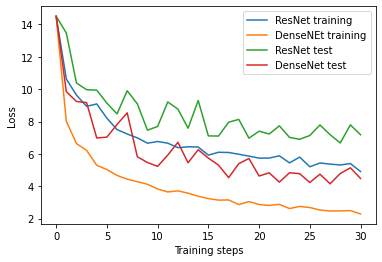

In [64]:

#do the visualization
#test loss and training loss
plt.figure()
line1, = plt.plot(resnet_losses)
line2, = plt.plot(densenet_losses)
line3, = plt.plot(res_test_losses)
line4, = plt.plot(dense_test_losses)

plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2, line3, line4),("ResNet training", "DenseNEt training", "ResNet test", "DenseNet test"))
plt.show()

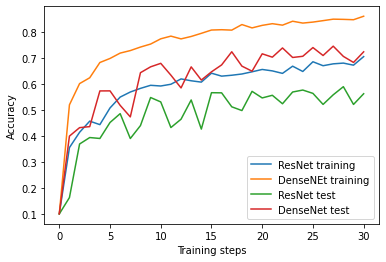

In [65]:
#do the visualization
#test and training accuracy
plt.figure()
line1, = plt.plot(resnet_accuracies)
line2, = plt.plot(densenet_accuracies)
line3, = plt.plot(res_test_accuracies)
line4, = plt.plot(dense_test_accuracies)

plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2, line3, line4),("ResNet training", "DenseNEt training", "ResNet test", "DenseNet test"))
plt.show()

In [ ]:
resnet.summary()


In [ ]:
densenet.summary()

XYZ As can be seen above our densenet performs slightly better than the resnet. ....